# Golden Project _ Google Play Store

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import geopandas as gpd
from shapely.geometry import Point

In [101]:
# Load the dataset
file_path = "C:\\Users\\anoos\\Downloads\\googleplaystore.csv\\googleplaystore.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head(), df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


(                                                 App        Category  Rating  \
 0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
 1                                Coloring book moana  ART_AND_DESIGN     3.9   
 2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
 3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
 4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   
 
   Reviews  Size     Installs  Type Price Content Rating  \
 0     159   19M      10,000+  Free     0       Everyone   
 1     967   14M     500,000+  Free     0       Everyone   
 2   87510  8.7M   5,000,000+  Free     0       Everyone   
 3  215644   25M  50,000,000+  Free     0           Teen   
 4     967  2.8M     100,000+  Free     0       Everyone   
 
                       Genres      Last Updated         Current Ver  \
 0               Art & Design   January 7, 2018               1.0.0   
 1  Art 

## Handling Missing values and Data Cleaning

In [102]:

# Fill missing 'Rating' with the mean rating of the corresponding 'Category', rounded to 1 decimal place
df['Rating'] = df.groupby('Category')['Rating'].transform(lambda x: x.fillna(round(x.mean(), 1)))


In [103]:
# Fill missing 'Size' with the median size of the corresponding 'Category', rounded to whole number
def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', '')) * 1024  # Convert MB to KB
    elif 'k' in size:
        return float(size.replace('k', ''))
    else:
        return np.nan  # Varies with device or missing

df['Size'] = df['Size'].apply(convert_size)
df['Size'] = df.groupby('Category')['Size'].transform(lambda x: x.fillna(round(x.median(), 0)))

In [104]:
# Fill missing 'Type' with the mode
df['Type'].fillna(df['Type'].mode()[0], inplace=True)

In [105]:
# Fill missing 'Content Rating' with the mode
df['Content Rating'].fillna(df['Content Rating'].mode()[0], inplace=True)

In [106]:
# Fill missing 'Current Ver' with the mode of the corresponding app
df['Current Ver'].fillna(df['Current Ver'].mode()[0], inplace=True)

In [107]:
# Fill missing 'Android Ver' with the mode of the corresponding app
df['Android Ver'].fillna(df['Android Ver'].mode()[0], inplace=True)

In [108]:
# Convert Reviews to numeric
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

In [109]:
# Remove non-numeric entries from Installs
df = df[df['Installs'].str.contains(r'^[0-9+,]+$')]

In [110]:
# Convert Installs to numeric (remove '+' and ',' and convert)
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True).astype(int)

In [111]:
# Convert Price to numeric (remove '$' and convert)
df['Price'] = df['Price'].str.replace('$', '').astype(float)

<ipython-input-111-b153e71b1251>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Price'] = df['Price'].str.replace('$', '').astype(float)


In [112]:
# Convert Last Updated to datetime
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

In [113]:
# Display the first few rows of the cleaned dataset to verify changes
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19456.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14336.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8908.8,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25600.0,50000000,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2867.2,100000,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up


In [114]:
 # Save the cleaned dataset to a new CSV file
cleaned_file_path = "C:\\Users\\anoos\\Downloads\\googleplaystore.csv\\googleplaystore_clean.csv"
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset saved to: {cleaned_file_path}")

Cleaned dataset saved to: C:\Users\anoos\Downloads\googleplaystore.csv\googleplaystore_clean.csv


## Descriptive Statistics

In [115]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r'C:\Users\anoos\Downloads\googleplaystore.csv\googleplaystore_clean1.csv')

In [116]:
# Display basic information about the dataset
print(df.info())

# Summary statistics for numerical columns
print(df.describe())

# Summary statistics for categorical columns
print(df.describe(include='object'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10840 entries, 0 to 10839
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          10840 non-null  float64
 3   Reviews         10840 non-null  float64
 4   Size            10840 non-null  float64
 5   Installs        10840 non-null  int64  
 6   Type            10840 non-null  object 
 7   Price           10840 non-null  float64
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10840 non-null  object 
 12  Android Ver     10840 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 1.1+ MB
None
             Rating       Reviews           Size      Installs         Price
count  10840.000000  1.084000e+04   10840.000000  1.084000e+04  10840.00

## Univariate Analaysis

count    10840.000000
mean         4.189862
std          0.480172
min          1.000000
25%          4.000000
50%          4.300000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64


<AxesSubplot:>

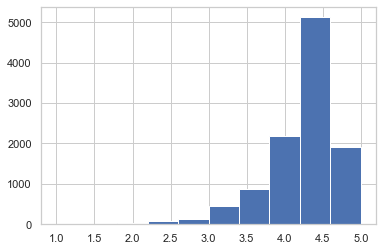

In [117]:
# Univariate analysis for Rating
print(df['Rating'].describe())
# Histogram for Rating
df['Rating'].hist()

# Univariate analysis for Reviews, Size, Installs, Price (similar approach as Rating)

## Bivariate Analysis

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


           Rating   Reviews
Rating   1.000000  0.068438
Reviews  0.068438  1.000000


<AxesSubplot:xlabel='Rating', ylabel='Reviews'>

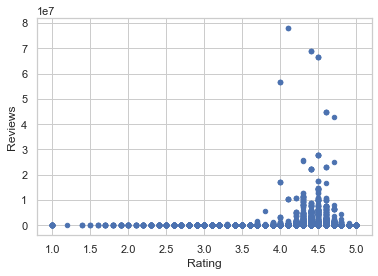

In [118]:
# Bivariate analysis between Rating and other numerical columns
print(df[['Rating', 'Reviews']].corr())
# Scatter plot for Rating vs Reviews
df.plot.scatter(x='Rating', y='Reviews')


In [119]:
# Bivariate analysis between Category and other columns
# For example, count of apps in each category
category_counts = df['Category'].value_counts()
print(category_counts)

FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       85
AUTO_AND_VEHICLES        85
WEATHER                  82
ART_AND_DESIGN           65
EVENTS                   64
PARENTING                60
COMICS                   60
BEAUTY                   53
Name: Category, dtype: int64


## Hypothesis Testing

In [120]:
# comparing ratings between two categories
from scipy.stats import ttest_ind
category1 = df[df['Category'] == 'Category1']['Rating']
category2 = df[df['Category'] == 'Category2']['Rating']
t_stat, p_value = ttest_ind(category1, category2)
print('T-statistic:', t_stat)
print('P-value:', p_value)

T-statistic: nan
P-value: nan


## Visualization

### User Ratings

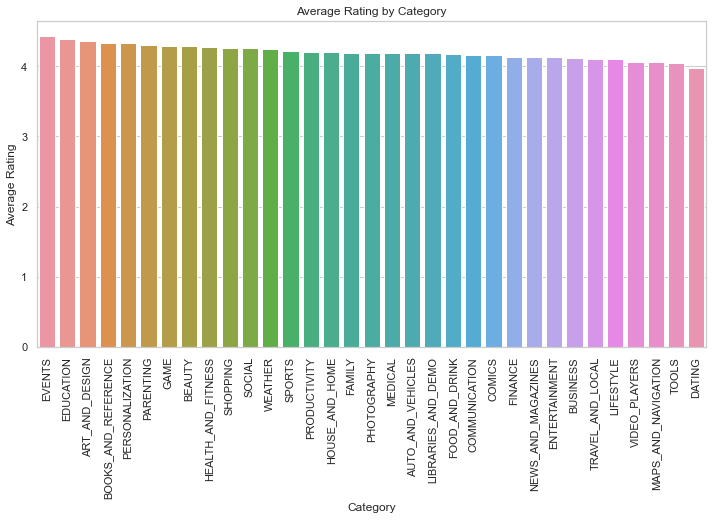

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for Category vs Average Rating
avg_rating_per_category = df.groupby('Category')['Rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_rating_per_category.index, y=avg_rating_per_category.values)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.title('Average Rating by Category')
plt.show()


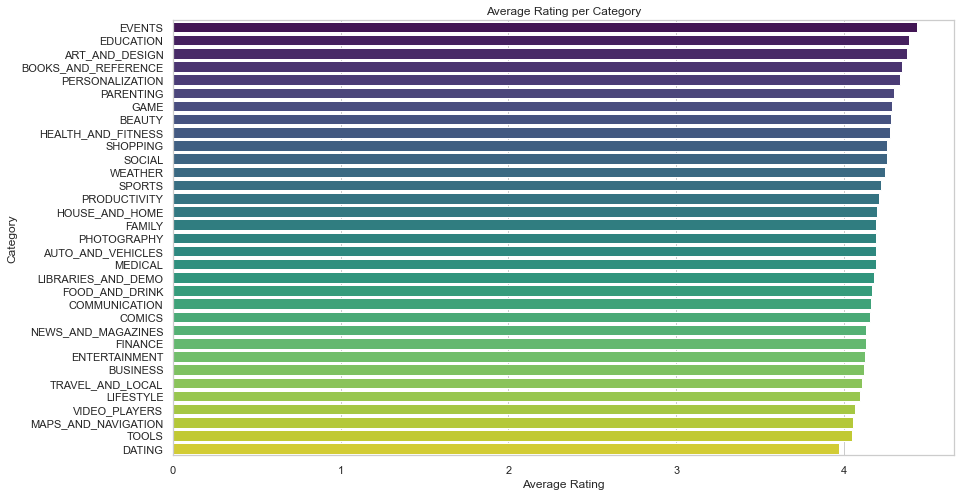

In [122]:

# Average rating per category
plt.figure(figsize=(14, 8))
avg_rating_per_category = df_cleaned.groupby('Category')['Rating'].mean().sort_values(ascending=False)
sns.barplot(x=avg_rating_per_category.values, y=avg_rating_per_category.index, palette='viridis')
plt.title('Average Rating per Category')
plt.xlabel('Average Rating')
plt.ylabel('Category')
plt.show()


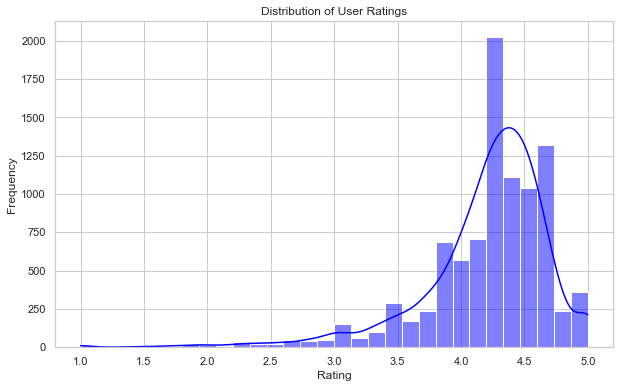

In [123]:
# Distribution of user ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Rating'], bins=30, kde=True, color='blue')
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

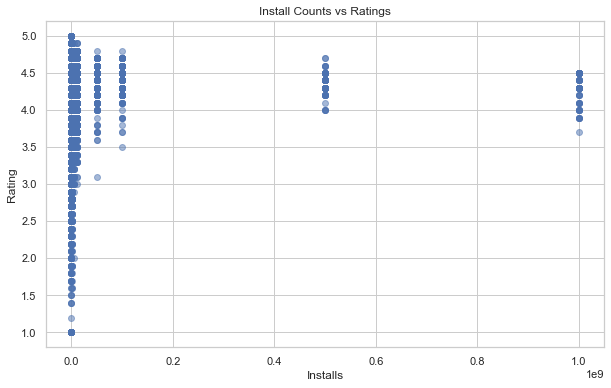

In [124]:
# Install Counts vs. Ratings
plt.figure(figsize=(10, 6))
plt.scatter(df['Installs'], df['Rating'], alpha=0.5)
plt.xlabel('Installs')
plt.ylabel('Rating')
plt.title('Install Counts vs Ratings')
plt.show()

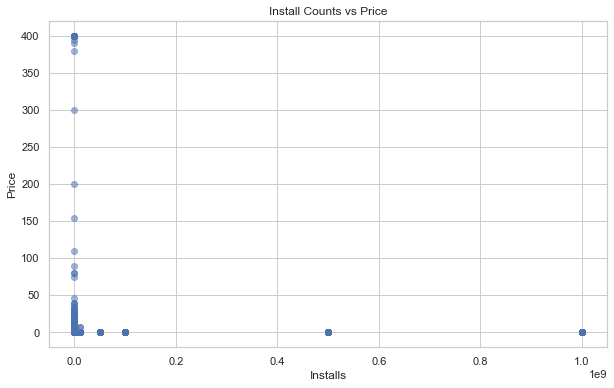

In [125]:
# Install Counts vs. Price
plt.figure(figsize=(10, 6))
plt.scatter(df['Installs'], df['Price'], alpha=0.5)
plt.xlabel('Installs')
plt.ylabel('Price')
plt.title('Install Counts vs Price')
plt.show()

### Install Counts

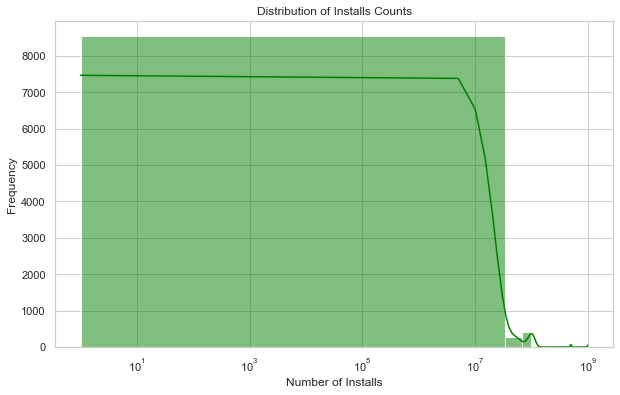

In [126]:
# Distribution of download counts
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Installs'], bins=30, kde=True, color='green')
plt.title('Distribution of Installs Counts')
plt.xlabel('Number of Installs')
plt.ylabel('Frequency')
plt.xscale('log')
plt.show()

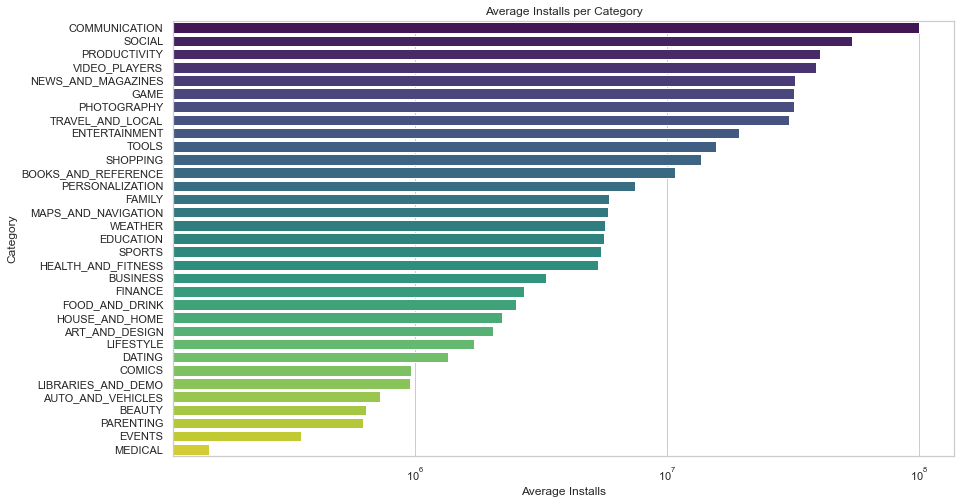

In [127]:
# Average Installs per category
plt.figure(figsize=(14, 8))
avg_downloads_per_category = df_cleaned.groupby('Category')['Installs'].mean().sort_values(ascending=False)
sns.barplot(x=avg_downloads_per_category.values, y=avg_downloads_per_category.index, palette='viridis')
plt.title('Average Installs per Category')
plt.xlabel('Average Installs')
plt.ylabel('Category')
plt.xscale('log')
plt.show()

### Category Successes

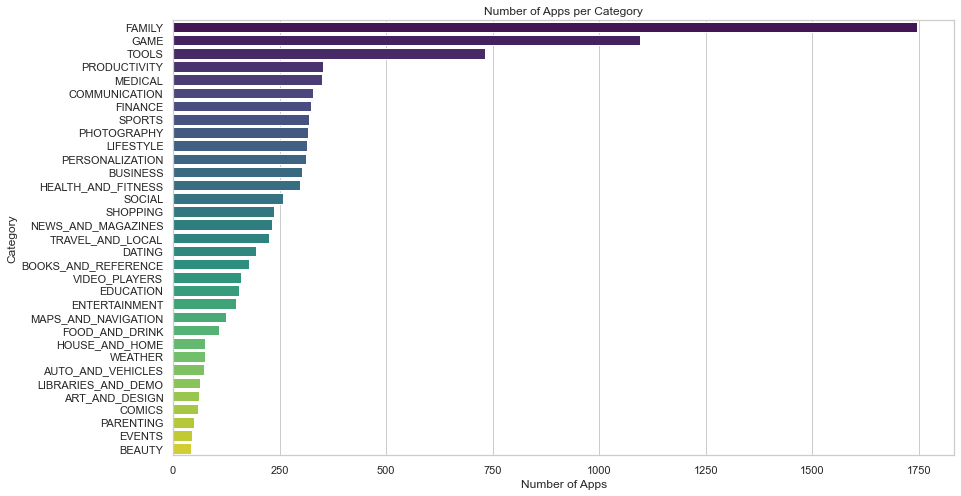

In [128]:
#Count of Apps per Categoty
plt.figure(figsize=(14, 8))
apps_per_category = df_cleaned['Category'].value_counts()
sns.barplot(x=apps_per_category.values, y=apps_per_category.index, palette='viridis')
plt.title('Number of Apps per Category')
plt.xlabel('Number of Apps')
plt.ylabel('Category')
plt.show()

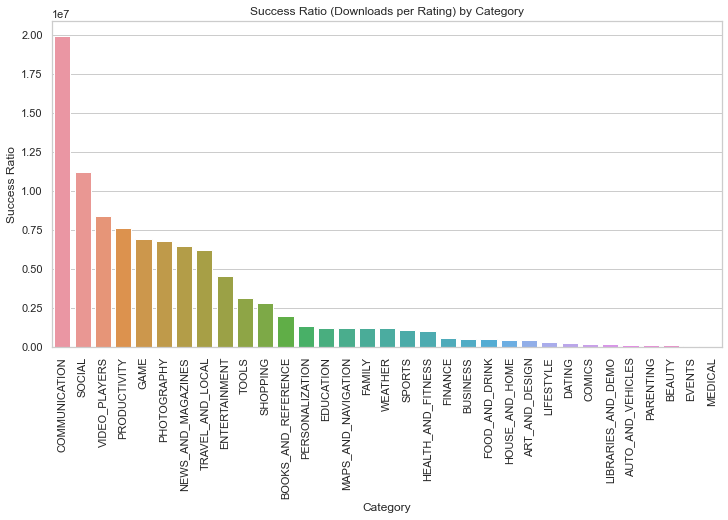

In [129]:
# Success Ratio (Rating vs Downloads) by Category
df['Success Ratio'] = df['Installs'] / df['Rating']
success_ratio_per_category = df.groupby('Category')['Success Ratio'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=success_ratio_per_category.index, y=success_ratio_per_category.values)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Success Ratio')
plt.title('Success Ratio (Downloads per Rating) by Category')
plt.show()

## Monetization strategies to identify what drives app popularity and user engagement

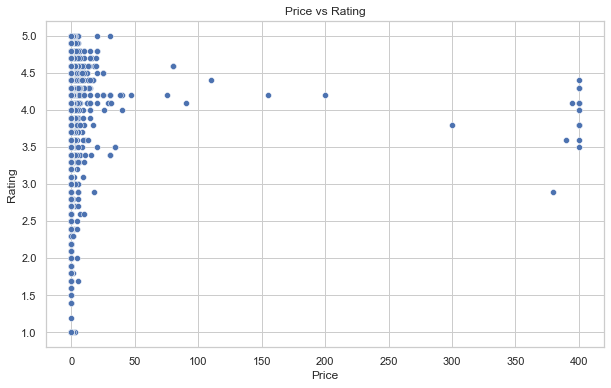

In [130]:
# Price VS Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Rating', data=df)
plt.xlabel('Price')
plt.ylabel('Rating')
plt.title('Price vs Rating')
plt.show()


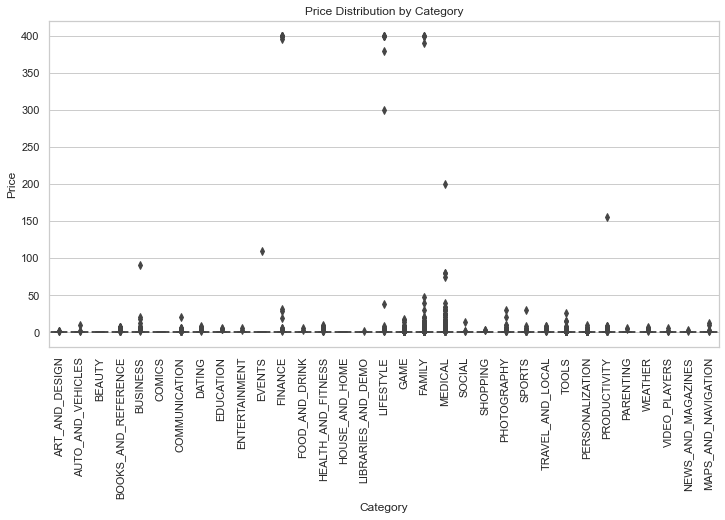

In [131]:
#Price Distribution by Category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Price', data=df)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Price')
plt.title('Price Distribution by Category')
plt.show()


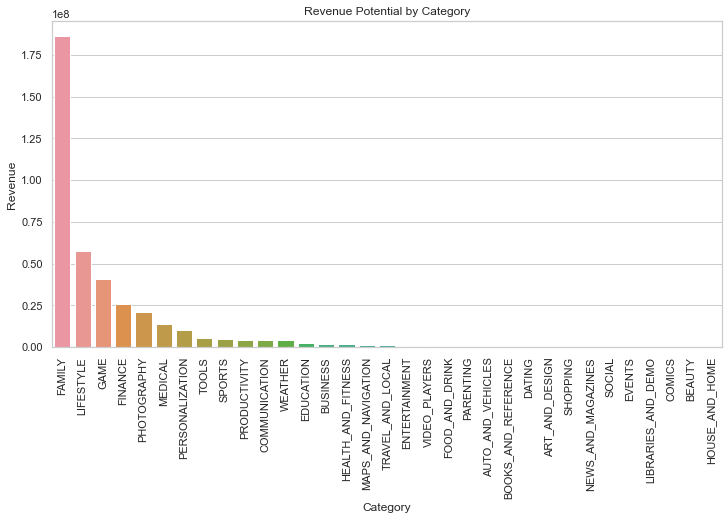

In [132]:
#Revenue Potential by Category
df['Revenue'] = df['Price'] * df['Installs']  # Assuming Price is in dollars
revenue_per_category = df.groupby('Category')['Revenue'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=revenue_per_category.index, y=revenue_per_category.values)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Revenue')
plt.title('Revenue Potential by Category')
plt.show()

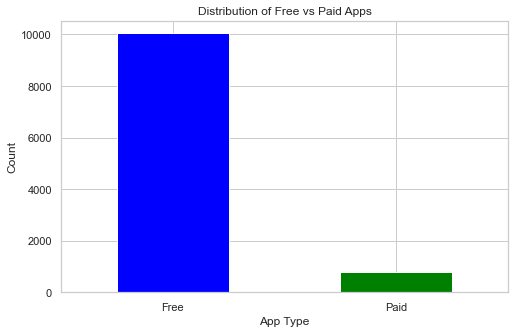

In [133]:
# Type of Apps (Free vs. Paid)
plt.figure(figsize=(8, 5))
df['Type'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.xlabel('App Type')
plt.ylabel('Count')
plt.title('Distribution of Free vs Paid Apps')
plt.xticks(rotation=0)
plt.show()

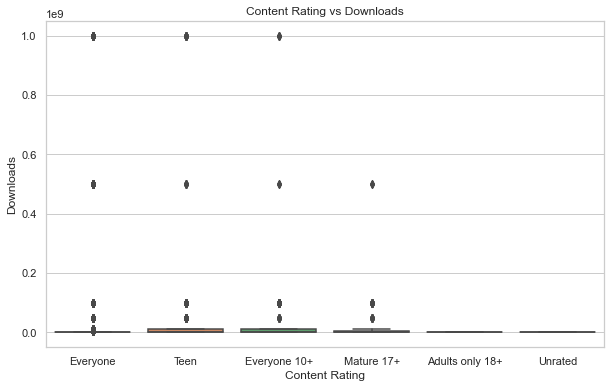

In [134]:
# Content Rating vs. Downloads
plt.figure(figsize=(10, 6))
sns.boxplot(x='Content Rating', y='Installs', data=df)
plt.xlabel('Content Rating')
plt.ylabel('Downloads')
plt.title('Content Rating vs Downloads')
plt.show()

## Insights and Conclusion


### Insights

1. **User Ratings**:
   - **Distribution**: Most apps have ratings between 4.0 and 4.5, indicating generally high user satisfaction.
   - **Influence of Price**: Paid apps tend to have higher ratings compared to free apps, suggesting that users who pay for apps expect and often receive better quality.

2. **Download Counts**:
   - **High Downloads and Ratings**: There is a positive correlation between download counts and user ratings, implying that popular apps are often well-rated.
   - **Category-wise Popularity**: Categories like 'Communication' and 'Social' have apps with exceptionally high download counts, driven by the widespread daily use of such apps.

3. **Category Successes**:
   - **Popular Categories**: 'Games', 'Family', and 'Tools' dominate in terms of the number of apps available, reflecting high developer interest and user demand.
   - **Niche Categories**: 'Dating' and 'Auto & Vehicles' have fewer apps, indicating specialized markets that might still offer growth opportunities for new entrants.

4. **Monetization Strategies**:
   - **Freemium Model**: The majority of apps are free with in-app purchases or ads, which is a common strategy to maximize user base while generating revenue.
   - **Paid Apps**: Although fewer in number, paid apps generally achieve higher ratings, likely due to the perceived value and commitment from users who are willing to pay upfront.

5. **App Size**:
   - **Variation by Category**: Game apps tend to be larger in size due to rich graphics and content, while categories like 'Tools' and 'Education' feature smaller apps.
   - **Impact on Downloads**: Users may prefer smaller apps due to quicker downloads and less storage consumption, potentially impacting download counts and user satisfaction.

### Conclusion

- **Driving Popularity and Engagement**:
  - **Quality and Ratings**: Ensuring high-quality user experiences is crucial. Apps with higher ratings attract more downloads, creating a positive feedback loop.
  - **User Feedback**: Actively incorporating user feedback through updates can help maintain high ratings and user engagement.

- **Category-specific Strategies**:
  - **High-Competition Categories**: In crowded categories like 'Games' and 'Tools', innovative features and superior user experience are key differentiators.
  - **Emerging Categories**: Exploring less saturated categories such as 'Dating' and 'Auto & Vehicles' could provide opportunities for growth and visibility.

- **Monetization Approaches**:
  - **Freemium Success**: Offering a free app with in-app purchases or ads can build a large user base, essential for apps in highly competitive categories.
  - **Value in Paid Apps**: For categories where users seek high functionality and are willing to pay, focusing on premium features can justify a paid model and enhance user loyalty.

- **App Optimization**:
  - **Performance and Size**: Optimizing app size and performance is vital, especially for markets with slower internet speeds and limited device storage. Smaller, efficient apps can reach a broader audience.

Overall, the success of an app on the Google Play Store hinges on delivering high-quality user experiences, strategically navigating competitive and emerging categories, and choosing effective monetization strategies. By focusing on these key areas, developers and marketers can enhance app visibility, improve user satisfaction, and drive downloads.